In [1]:
from hubmap.visualization import visualize_checkpoint
from hubmap.visualization import visualize_random_image, ImageType
from hubmap.models import DPT
from hubmap.models.dpt import Backbone

(<Figure size 400x400 with 1 Axes>, <Figure size 400x400 with 1 Axes>)

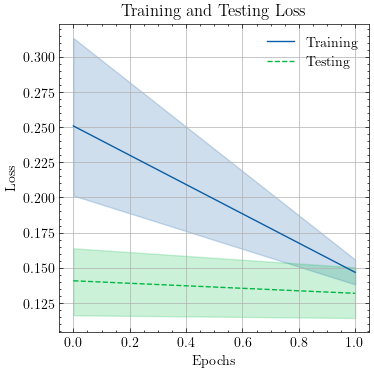

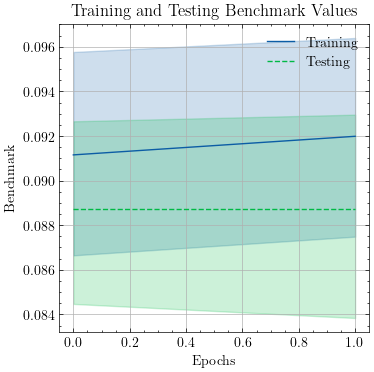

In [2]:
visualize_checkpoint("fct_trials")

/home/jflxb/miniconda3/envs/J/lib/python3.11/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


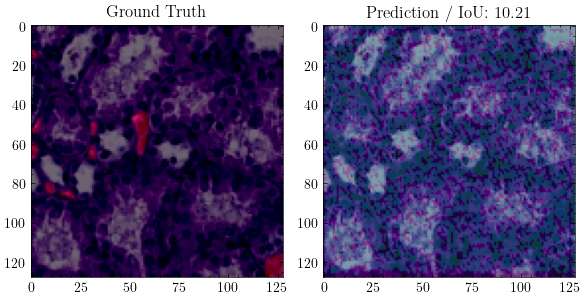

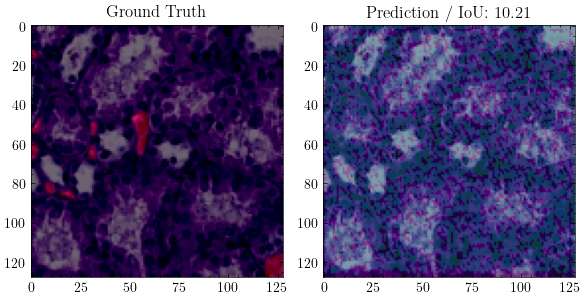

In [3]:
from hubmap.models import FCT
from hubmap.models import init_weights

model = FCT(in_channels=3, num_classes=3)
model.apply(init_weights)
visualize_random_image(model, "fct_trials", ImageType.expert, seed=42, pred_idx=2)

In [ ]:
model = DPT(num_classes=3, backbone=Backbone.vitb16_384, use_pretrained=True)
visualize_random_image(model, "dpt_vitb16_384_scratch", ImageType.expert, seed=42)